In [85]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations

In [192]:
dataset = 'ssc.hg38'
ped_file = '../../DATA/ssc.hg38/ssc.ped'

colors = ['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]


In [87]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))




ped loaded
children 9371


# select crossover/noncrossover threshold

In [128]:
def pull_inter_recomb_distance(recombinations):
    child_to_recombs = defaultdict(list)

    for r in recombinations:
        child_to_recombs[tuple(r['child'])].append(r)

    recomb_intervals_mat = []
    recomb_intervals_pat = []
    for rs in child_to_recombs.values():
        for chrom in [str(x) for x in range(1, 23)]:

            mat_rs = sorted([r for r in rs if r['chrom']==chrom and r['is_mat'] and (not r['is_hts'])], key=lambda x: x['start_pos'])
            if len(mat_rs)>0:
                prev_r = mat_rs[0]
                for r in mat_rs[1:]:
                    recomb_intervals_mat.append(r['start_pos'] - prev_r['end_pos']) 
                    prev_r = r

            pat_rs = sorted([r for r in rs if r['chrom']==chrom and r['is_pat'] and (not r['is_hts'])], key=lambda x: x['start_pos'])
            if len(pat_rs)>0:
                prev_r = pat_rs[0]
                for r in pat_rs[1:]:
                    recomb_intervals_pat.append(r['start_pos'] - prev_r['end_pos'])    
                    prev_r = r
    return recomb_intervals_mat, recomb_intervals_pat


In [216]:
with open('../../PhasingFamilies/recomb_%s/recombinations.json' % dataset, 'r') as f:
#with open('../phased_ihart.ms2_quads_del_X/crossovers.json', 'r') as f:
    recombinations = [x for x in json.load(f)]
recomb_intervals_mat, recomb_intervals_pat = pull_inter_recomb_distance(recombinations)

with open('../../PhasingFamilies/recomb_%s/recombinations.json' % 'spark', 'r') as f:
#with open('../phased_ihart.ms2_quads_del_X/crossovers.json', 'r') as f:
    recombinations_array = [x for x in json.load(f)]
recomb_intervals_mat_array, recomb_intervals_pat_array = pull_inter_recomb_distance(recombinations_array)

with open('../../PhasingFamilies/recomb_%s/crossovers.json' % dataset, 'r') as f:
#with open('../phased_ihart.ms2_quads_del_X/crossovers.json', 'r') as f:
    crossovers = [x for x in json.load(f)]
cross_intervals_mat, cross_intervals_pat = pull_inter_recomb_distance(crossovers)


In [218]:
print(np.quantile(recomb_intervals_mat_array, 0.01), np.quantile(recomb_intervals_pat_array, 0.01))

161332.16 154265.4


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log10


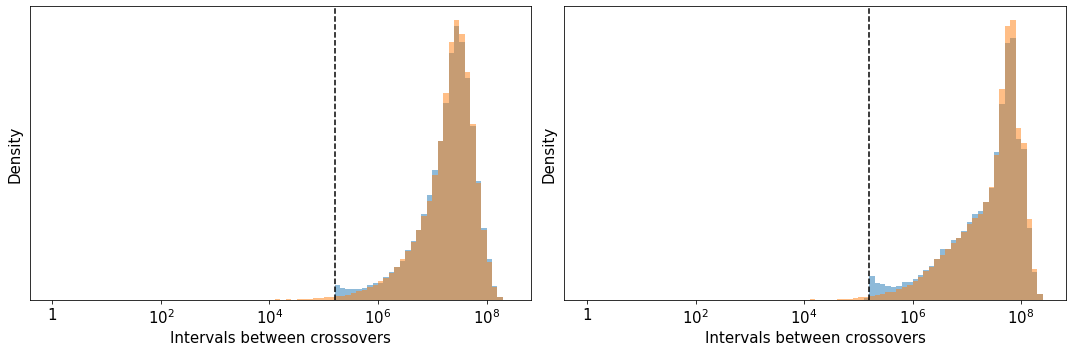

In [225]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log10(cross_intervals_mat), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(recomb_intervals_mat_array), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.axvline(np.log10(np.quantile(recomb_intervals_mat_array, 0.01)), color='black', linestyle='--')
plt.xticks(np.arange(0, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9, 2)], fontsize=15)
plt.yticks([])
plt.ylabel('Density', fontsize=15)
plt.xlabel('Intervals between crossovers', fontsize=15)

plt.subplot(1, 2, 2)
plt.hist(np.log10(cross_intervals_pat), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(recomb_intervals_pat_array), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.axvline(np.log10(np.quantile(recomb_intervals_pat_array, 0.01)), color='black', linestyle='--')
plt.xticks(np.arange(0, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9, 2)], fontsize=15)
plt.yticks([])
plt.ylabel('Density', fontsize=15)
plt.xlabel('Intervals between crossovers', fontsize=15)

plt.tight_layout()
plt.show()


In [234]:
print(np.median(cross_intervals_mat), np.median(cross_intervals_pat))


23349429.0 38155890.5


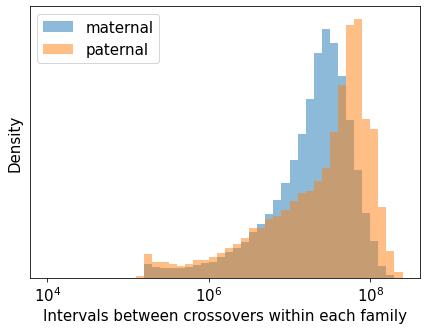

In [233]:
plt.figure(figsize=(7, 5))

plt.hist(np.log10(cross_intervals_mat), bins=np.arange(4, 8.5, 0.1), alpha=0.5, density=True, label='maternal')
plt.hist(np.log10(cross_intervals_pat), bins=np.arange(4, 8.5, 0.1), alpha=0.5, density=True, label='paternal')
plt.xticks(np.arange(4, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(4, 9, 2)], fontsize=15)
plt.yticks([])
plt.ylabel('Density', fontsize=15)
plt.xlabel('Intervals between crossovers within each family', fontsize=15)
plt.legend(fontsize=15)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


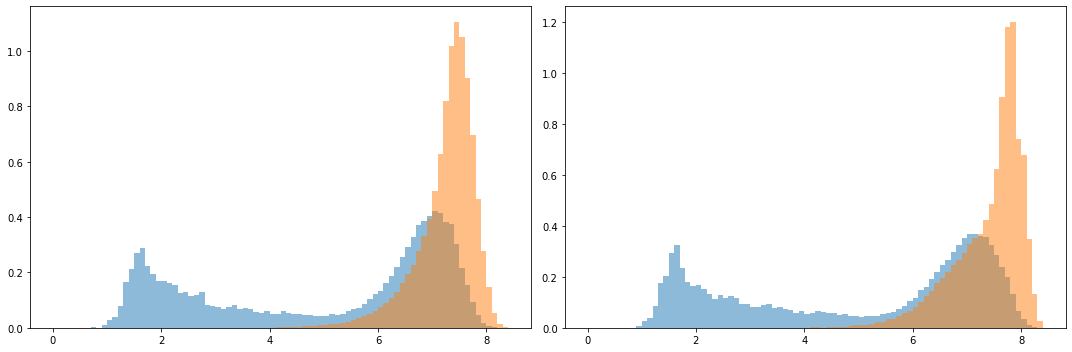

In [220]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log10(recomb_intervals_mat), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(recomb_intervals_mat_array), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)

plt.subplot(1, 2, 2)
plt.hist(np.log10(recomb_intervals_pat), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(recomb_intervals_pat_array), bins=np.arange(0, 8.5, 0.1), alpha=0.5, density=True)

plt.tight_layout()
plt.show()


In [146]:
with open('../../PhasingFamilies/recomb_%s/crossovers.json' % dataset, 'r') as f:
#with open('../phased_ihart.ms2_quads_del_X/crossovers.json', 'r') as f:
    crossovers = [x for x in json.load(f)]

In [147]:
# Kong et al
assembly='38'
crossover_len_mat_kong, crossover_len_pat_kong = [], []
with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        if chrom != 'X':
            start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
            crossover_len_mat_kong.append(end_pos-start_pos)
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        if chrom != 'X':
            start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
            crossover_len_pat_kong.append(end_pos-start_pos)

In [148]:
# Halldorson et al
crossover_len_mat_halldorson, crossover_len_pat_halldorson = [], []
crossover_len_mat_halldorson_wgs, crossover_len_pat_halldorson_wgs = [], []
with open('../data/Halldorson2019/aau1043_datas4', 'r') as f:
    header = next(f)
    while header.startswith('#'):
        header = next(f)
    for line in f:
        pieces = line.strip().split('\t')
        chrom = pieces[0][3:]
        if pieces[6]=='NA' or pieces[6]=='0' and chrom != 'X':
            start_pos, end_pos = int(pieces[1]), int(pieces[2])
            if pieces[4]=='P':
                crossover_len_pat_halldorson.append(end_pos-start_pos)
            else:
                crossover_len_mat_halldorson.append(end_pos-start_pos)
        if pieces[6]=='0':
            start_pos, end_pos = int(pieces[1]), int(pieces[2])
            if pieces[4]=='P':
                crossover_len_pat_halldorson_wgs.append(end_pos-start_pos)
            else:
                crossover_len_mat_halldorson_wgs.append(end_pos-start_pos)

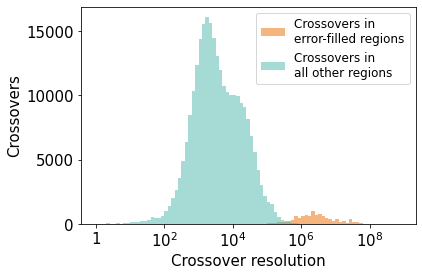

In [193]:

crossover_lengths_nohts = [x['end_pos']-x['start_pos'] for x in crossovers if (not x['is_hts'])]
crossover_lengths_hts = [x['end_pos']-x['start_pos'] for x in crossovers if x['is_hts']]

plt.hist(np.log10(crossover_lengths_hts), bins=np.arange(0, 9, 0.1), 
         alpha=0.5, label='Crossovers in\nerror-filled regions', color=colors[0])

plt.hist(np.log10(crossover_lengths_nohts), bins=np.arange(0, 9, 0.1), 
         alpha=0.5, label='Crossovers in\nall other regions', color=colors[1])
plt.xticks(np.arange(0, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9, 2)], fontsize=15)
plt.yticks(np.arange(0, 20000, 5000), fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Crossover resolution', fontsize=15)
plt.ylabel('Crossovers', fontsize=15)

plt.show()

In [201]:
crossover_lengths = [x['end_pos']-x['start_pos'] for x in crossovers]


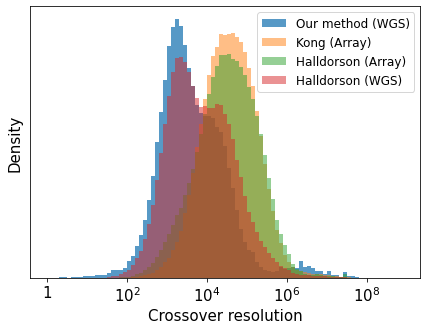

In [206]:

plt.figure(figsize=(7, 5))
plt.hist(np.log10(crossover_lengths), bins=np.arange(0, 9, 0.1), 
         alpha=0.75, density=True, label='Our method (WGS)')
plt.hist(np.log10(crossover_len_mat_kong + crossover_len_pat_kong), bins=np.arange(0, 9, 0.1), 
         alpha=0.5, density=True, label='Kong (Array)')
plt.hist(np.log10(crossover_len_mat_halldorson + crossover_len_pat_halldorson), bins=np.arange(0, 9, 0.1), 
         alpha=0.5, density=True, label='Halldorson (Array)')
plt.hist(np.log10(crossover_len_mat_halldorson_wgs + crossover_len_pat_halldorson_wgs), bins=np.arange(0, 9, 0.1), 
         alpha=0.5, density=True, label='Halldorson (WGS)')

plt.legend(fontsize=12)
plt.xticks(np.arange(0, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9, 2)], fontsize=15)
plt.xlabel('Crossover resolution', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.yticks([])

plt.show()

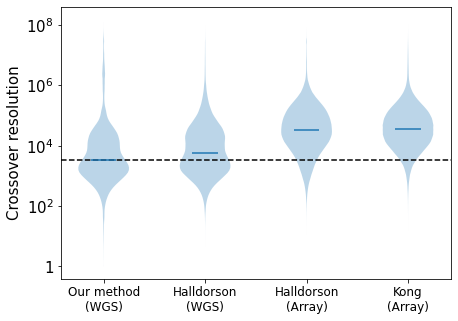

In [215]:

plt.figure(figsize=(7, 5))
plt.axhline(np.median(np.log10(crossover_lengths)), color='black', linestyle='--')
plt.violinplot([np.log10(crossover_lengths),
                np.log10(crossover_len_mat_halldorson_wgs + crossover_len_pat_halldorson_wgs),
                np.log10(crossover_len_mat_halldorson + crossover_len_pat_halldorson),
                np.log10(crossover_len_mat_kong + crossover_len_pat_kong),
                ],
              showmedians=True, showextrema=False) 

plt.yticks(np.arange(0, 9, 2), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9, 2)], fontsize=15)
plt.ylabel('Crossover resolution', fontsize=15)
plt.xticks(np.arange(1, 5), ['Our method\n(WGS)', 'Halldorson\n(WGS)', 'Halldorson\n(Array)', 'Kong\n(Array)'], 
           fontsize=12)

plt.show()

In [208]:
print(len(crossover_len_mat_halldorson_wgs)/(len(crossover_len_mat_halldorson) + len(crossover_len_mat_halldorson_wgs)))

0.10105124213492124


In [227]:
print(np.median(lengths), 
      np.median(crossover_len_mat_halldorson_wgs + crossover_len_pat_halldorson_wgs), 
      np.median(crossover_len_mat_kong + crossover_len_pat_kong))
print(np.median(crossover_len_mat_halldorson_wgs + crossover_len_pat_halldorson_wgs)/np.median(lengths))


3371.0 5914.0 36704.0
1.7543755562147731


In [151]:
sibpair_to_num_mat_crossovers = defaultdict(int)
sibpair_to_num_pat_crossovers = defaultdict(int)
for x in crossovers:
    if x['is_mat'] and (x['chrom'] != 'X'):
        sibpair_to_num_mat_crossovers[tuple(x['child'])] += 1
    elif (not x['is_mat']) and (x['chrom'] != 'X'):
        sibpair_to_num_pat_crossovers[tuple(x['child'])] += 1

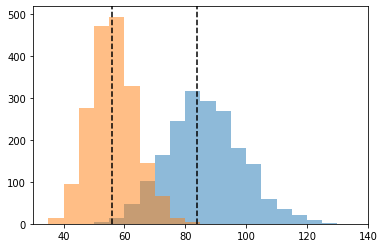

In [152]:
plt.hist(sibpair_to_num_mat_crossovers.values(), alpha=0.5, bins=np.arange(35, 140, 5))
plt.hist(sibpair_to_num_pat_crossovers.values(), alpha=0.5, bins=np.arange(35, 140, 5))
plt.axvline(84, color='black', linestyle='--')
plt.axvline(56, color='black', linestyle='--')
plt.show()

In [154]:
print(np.median(list(sibpair_to_num_mat_crossovers.values())))
print(np.median(list(sibpair_to_num_pat_crossovers.values())))
#84 56

85.0
55.0


In [104]:
for x in crossovers:
    if not x['is_complex'] and x['chrom'] != 'X':
        if x['end_pos'] - x['start_pos'] > 1000000:
            print('chr%s:%d-%d' % (x['chrom'], x['start_pos'], x['end_pos']), x['is_hts'], x['family'], x['child'])
            print(x)

chr7:72458823-77096261 False 11012 ['SSC00827', 'SSC00838']
{'family': '11012', 'chrom': '7', 'start_pos': 72458823, 'end_pos': 77096261, 'child': ['SSC00827', 'SSC00838'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11012', 'chrom': '7', 'start_pos': 72458823, 'end_pos': 77096261, 'child': ['SSC00827', 'SSC00838'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC00836', 'dad': 'SSC00837', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC00836', 'dad': 'SSC00837'}
chr7:148900278-150292992 False 11012 ['SSC00827', 'SSC00838']
{'family': '11012', 'chrom': '7', 'start_pos': 148900278, 'end_pos': 150292992, 'child': ['SSC00827', 'SSC00838'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11012', 'chrom': '7', 'start_pos': 148900278, 'end_pos': 150292992

{'family': '14303', 'chrom': '7', 'start_pos': 72501399, 'end_pos': 77063965, 'child': ['SSC11251', 'SSC11261'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '14303', 'chrom': '7', 'start_pos': 72501399, 'end_pos': 77063965, 'child': ['SSC11251', 'SSC11261'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC11255', 'dad': 'SSC11258', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC11255', 'dad': 'SSC11258'}
chr19:48342109-51357368 False 14303 ['SSC11251', 'SSC11261']
{'family': '14303', 'chrom': '19', 'start_pos': 48342109, 'end_pos': 51357368, 'child': ['SSC11251', 'SSC11261'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '14303', 'chrom': '19', 'start_pos': 48342109, 'end_pos': 51357368, 'child': ['SSC11251', 'SSC11261'], 'is_mat': False, 'is_pat':

{'family': '13251', 'chrom': '7', 'start_pos': 55680175, 'end_pos': 63925840, 'child': ['SSC07517', 'SSC07502'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13251', 'chrom': '7', 'start_pos': 55680175, 'end_pos': 63925840, 'child': ['SSC07517', 'SSC07502'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC07509', 'dad': 'SSC07499', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC07509', 'dad': 'SSC07499'}
chr15:43580520-44618337 False 13251 ['SSC07517', 'SSC07502']
{'family': '13251', 'chrom': '15', 'start_pos': 43580520, 'end_pos': 44618337, 'child': ['SSC07517', 'SSC07502'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13251', 'chrom': '15', 'start_pos': 43580520, 'end_pos': 44618337, 'child': ['SSC07517', 'SSC07502'], 'is_mat': True, 'is_pat': 

chr19:39877633-42816978 False 11933 ['SSC04663', 'SSC04654']
{'family': '11933', 'chrom': '19', 'start_pos': 39877633, 'end_pos': 42816978, 'child': ['SSC04663', 'SSC04654'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11933', 'chrom': '19', 'start_pos': 39877633, 'end_pos': 42816978, 'child': ['SSC04663', 'SSC04654'], 'is_mat': False, 'is_pat': True, 'family_size': 4, 'mom': 'SSC04658', 'dad': 'SSC03491', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC04658', 'dad': 'SSC03491'}
chr22:16258000-18967555 False 11933 ['SSC04663', 'SSC04654']
{'family': '11933', 'chrom': '22', 'start_pos': 16258000, 'end_pos': 18967555, 'child': ['SSC04663', 'SSC04654'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11933', 'chrom': '22', 'start_pos': 16258000, 'end_pos': 18967555

chr19:2654405-6804721 False 14574 ['SSC12609', 'SSC12610']
{'family': '14574', 'chrom': '19', 'start_pos': 2654405, 'end_pos': 6804721, 'child': ['SSC12609', 'SSC12610'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '14574', 'chrom': '19', 'start_pos': 2654405, 'end_pos': 6804721, 'child': ['SSC12609', 'SSC12610'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC12604', 'dad': 'SSC12608', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC12604', 'dad': 'SSC12608'}
chr19:2654405-6804721 False 14574 ['SSC12609', 'SSC12610']
{'family': '14574', 'chrom': '19', 'start_pos': 2654405, 'end_pos': 6804721, 'child': ['SSC12609', 'SSC12610'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '14574', 'chrom': '19', 'start_pos': 2654405, 'end_pos': 6804721, 'child': [

chr18:78651537-79943576 False 13583 ['SSC08152', 'SSC08151']
{'family': '13583', 'chrom': '18', 'start_pos': 78651537, 'end_pos': 79943576, 'child': ['SSC08152', 'SSC08151'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13583', 'chrom': '18', 'start_pos': 78651537, 'end_pos': 79943576, 'child': ['SSC08152', 'SSC08151'], 'is_mat': False, 'is_pat': True, 'family_size': 4, 'mom': 'SSC08156', 'dad': 'SSC08159', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC08156', 'dad': 'SSC08159'}
chr19:40814635-43035870 False 13583 ['SSC08152', 'SSC08151']
{'family': '13583', 'chrom': '19', 'start_pos': 40814635, 'end_pos': 43035870, 'child': ['SSC08152', 'SSC08151'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13583', 'chrom': '19', 'start_pos': 40814635, 'end_pos': 43035870

chr3:195244553-196479282 False 13424 ['SSC07950', 'SSC07961']
{'family': '13424', 'chrom': '3', 'start_pos': 195244553, 'end_pos': 196479282, 'child': ['SSC07950', 'SSC07961'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13424', 'chrom': '3', 'start_pos': 195244553, 'end_pos': 196479282, 'child': ['SSC07950', 'SSC07961'], 'is_mat': False, 'is_pat': True, 'family_size': 4, 'mom': 'SSC07955', 'dad': 'SSC07960', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC07955', 'dad': 'SSC07960'}
chr5:69117854-71372831 False 13424 ['SSC07950', 'SSC07961']
{'family': '13424', 'chrom': '5', 'start_pos': 69117854, 'end_pos': 71372831, 'child': ['SSC07950', 'SSC07961'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13424', 'chrom': '5', 'start_pos': 69117854, 'end_pos': 71372831

chr2:86864112-87984096 False 13322 ['SSC07028', 'SSC07040']
{'family': '13322', 'chrom': '2', 'start_pos': 86864112, 'end_pos': 87984096, 'child': ['SSC07028', 'SSC07040'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13322', 'chrom': '2', 'start_pos': 86864112, 'end_pos': 87984096, 'child': ['SSC07028', 'SSC07040'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC07033', 'dad': 'SSC07039', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC07033', 'dad': 'SSC07039'}
chr9:38794586-68402345 False 13322 ['SSC07028', 'SSC07040']
{'family': '13322', 'chrom': '9', 'start_pos': 38794586, 'end_pos': 68402345, 'child': ['SSC07028', 'SSC07040'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13322', 'chrom': '9', 'start_pos': 38794586, 'end_pos': 68402345, 'chi

{'family': '11339', 'chrom': '2', 'start_pos': 109749038, 'end_pos': 112440907, 'child': ['SSC00724', 'SSC00648'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11339', 'chrom': '2', 'start_pos': 109749038, 'end_pos': 112440907, 'child': ['SSC00724', 'SSC00648'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC00654', 'dad': 'SSC00653', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC00654', 'dad': 'SSC00653'}
chr10:45678920-48148406 False 11339 ['SSC00724', 'SSC00648']
{'family': '11339', 'chrom': '10', 'start_pos': 45678920, 'end_pos': 48148406, 'child': ['SSC00724', 'SSC00648'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11339', 'chrom': '10', 'start_pos': 45678920, 'end_pos': 48148406, 'child': ['SSC00724', 'SSC00648'], 'is_mat': True, 'is_pa

{'family': '11740', 'chrom': '19', 'start_pos': 10297215, 'end_pos': 14421110, 'child': ['SSC03082', 'SSC03064'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11740', 'chrom': '19', 'start_pos': 10297215, 'end_pos': 14421110, 'child': ['SSC03082', 'SSC03064'], 'is_mat': False, 'is_pat': True, 'family_size': 4, 'mom': 'SSC03072', 'dad': 'SSC03081', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC03072', 'dad': 'SSC03081'}
chr22:20329402-22652911 False 11740 ['SSC03082', 'SSC03064']
{'family': '11740', 'chrom': '22', 'start_pos': 20329402, 'end_pos': 22652911, 'child': ['SSC03082', 'SSC03064'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '11740', 'chrom': '22', 'start_pos': 20329402, 'end_pos': 22652911, 'child': ['SSC03082', 'SSC03064'], 'is_mat': False, 'is_pat

chr19:15173074-27389314 False 12671 ['SSC05208', 'SSC05198']
{'family': '12671', 'chrom': '19', 'start_pos': 15173074, 'end_pos': 27389314, 'child': ['SSC05208', 'SSC05198'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '12671', 'chrom': '19', 'start_pos': 15173074, 'end_pos': 27389314, 'child': ['SSC05208', 'SSC05198'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC05202', 'dad': 'SSC05207', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC05202', 'dad': 'SSC05207'}
chr1:25184760-29126387 False 12688 ['SSC05372', 'SSC05388']
{'family': '12688', 'chrom': '1', 'start_pos': 25184760, 'end_pos': 29126387, 'child': ['SSC05372', 'SSC05388'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '12688', 'chrom': '1', 'start_pos': 25184760, 'end_pos': 29126387, '

chr1:25280824-28858344 False 13227 ['SSC08500', 'SSC08507']
{'family': '13227', 'chrom': '1', 'start_pos': 25280824, 'end_pos': 28858344, 'child': ['SSC08500', 'SSC08507'], 'is_mat': False, 'is_pat': True, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13227', 'chrom': '1', 'start_pos': 25280824, 'end_pos': 28858344, 'child': ['SSC08500', 'SSC08507'], 'is_mat': False, 'is_pat': True, 'family_size': 4, 'mom': 'SSC08503', 'dad': 'SSC08506', 'is_left_match': True, 'is_right_match': False, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC08503', 'dad': 'SSC08506'}
chr9:38785308-68414685 False 13227 ['SSC08500', 'SSC08507']
{'family': '13227', 'chrom': '9', 'start_pos': 38785308, 'end_pos': 68414685, 'child': ['SSC08500', 'SSC08507'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13227', 'chrom': '9', 'start_pos': 38785308, 'end_pos': 68414685, 'chi

chr16:14578138-16755619 False 13798 ['SSC08653', 'SSC08640']
{'family': '13798', 'chrom': '16', 'start_pos': 14578138, 'end_pos': 16755619, 'child': ['SSC08653', 'SSC08640'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13798', 'chrom': '16', 'start_pos': 14578138, 'end_pos': 16755619, 'child': ['SSC08653', 'SSC08640'], 'is_mat': True, 'is_pat': False, 'family_size': 4, 'mom': 'SSC08645', 'dad': 'SSC08652', 'is_left_match': False, 'is_right_match': True, 'is_other_parent_match': False, 'is_other_parent_mismatch': False, 'is_hts': False}], 'family_size': 4, 'mom': 'SSC08645', 'dad': 'SSC08652'}
chr19:44411249-49361161 False 13798 ['SSC08653', 'SSC08640']
{'family': '13798', 'chrom': '19', 'start_pos': 44411249, 'end_pos': 49361161, 'child': ['SSC08653', 'SSC08640'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'is_hts': False, 'recombinations': [{'family': '13798', 'chrom': '19', 'start_pos': 44411249, 'end_pos': 49361161

KeyboardInterrupt: 

In [77]:
print(np.median(lengths_mat))
print(np.median(crossover_len_mat_halldorson_wgs))

3298.0
5970.0


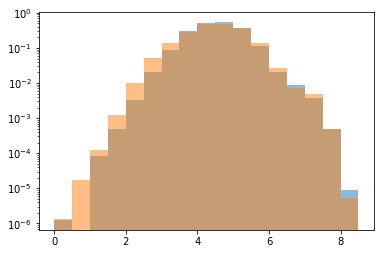

In [78]:
plt.hist(np.log10(crossover_len_mat_kong), log=True, alpha=0.5, density=True, bins=np.arange(0, 9, 0.5))
plt.hist(np.log10(crossover_len_mat_halldorson), log=True, alpha=0.5, density=True, bins=np.arange(0, 9, 0.5))
plt.show()